# Medical Insurance Cost – Full Training & Debug Notebook 💵🏥

This notebook walks through **data exploration, baseline modelling, model improvement, and artefact export** for the Medical Insurance dataset.

Run the notebook top‑to‑bottom once. If any cell errors, read the orange **Debug Tips** markdown blocks – they flag the common causes.

Outputs used by the Streamlit UI:
* `preprocess.pkl`
* `feature_names.pkl`
* `rf_model.pkl`


In [1]:
# %% 1. Imports
import pandas as pd, numpy as np, pickle, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams['figure.figsize'] = (6,4)
print('✅ libraries imported')

✅ libraries imported


In [2]:
# %% 2. Load data
DATA = Path('medical_insurance.csv')  # change if needed
df = pd.read_csv(DATA)

display(df.head())
df.info()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


## Quick EDA
* Distribution plots for numeric variables
* Correlation heat‑map
* Mean charges by smoker / region

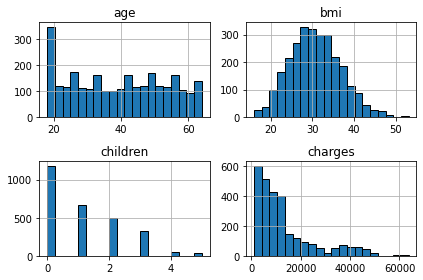

In [3]:
# %% 3a. Numeric distributions
num_cols = ['age','bmi','children','charges']
df[num_cols].hist(bins=20, layout=(2,2), edgecolor='black')
plt.tight_layout();

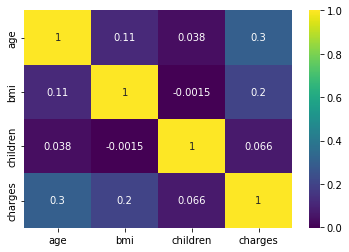

In [4]:
# %% 3b. Correlation heat‑map
sns.heatmap(df[num_cols].corr(), annot=True, cmap='viridis');

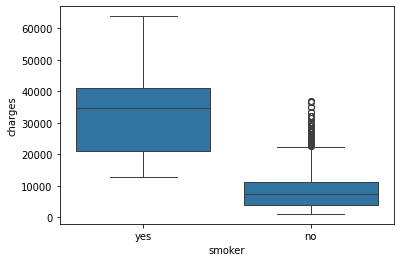

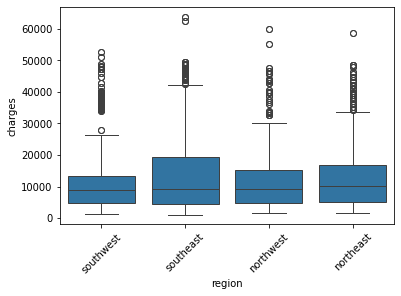

In [5]:
# %% 3c. Charges by smoker & region
sns.boxplot(x='smoker', y='charges', data=df); plt.show();
sns.boxplot(x='region', y='charges', data=df); plt.xticks(rotation=45); plt.show();

In [6]:
# %% 4. Train/Valid split
y = df['charges']
X = df.drop(columns='charges')
cat_cols = ['sex','smoker','region']
num_cols = ['age','bmi','children']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker'])
print(X_train.shape, X_valid.shape)

(2217, 6) (555, 6)


In [7]:
# %% 5. Preprocessing pipeline
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
preprocess.fit(X_train)  # ⚠️ Must run before any .transform or model.fit

X_train_t = preprocess.transform(X_train)
X_valid_t = preprocess.transform(X_valid)

feature_names = list(preprocess.named_transformers_['num'].get_feature_names_out(num_cols)) + \
                list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
print('Feature matrix shape:', X_train_t.shape)

Feature matrix shape: (2217, 11)


In [8]:
# %% 6. Baseline Multiple Linear Regression
lin = LinearRegression()
lin.fit(X_train_t, y_train)
pred_lin = lin.predict(X_valid_t)

def metrics(y_true, y_pred):
    return pd.Series({
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE' : mean_absolute_error(y_true, y_pred),
        'R2'  : r2_score(y_true, y_pred)

    })

def metrics(y_true, y_pred):
    return pd.Series({
        'RMSE': mean_squared_error(y_true, y_pred) ** 0.5,
        'MAE' : mean_absolute_error(y_true, y_pred),
        'R2'  : r2_score(y_true, y_pred)
    })

baseline_metrics = metrics(y_valid, pred_lin)
baseline_metrics

RMSE    6228.651739
MAE     4371.398819
R2         0.726818
dtype: float64

In [9]:
# %% 7. Random‑Forest Regressor (improved model)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_t, y_train)
pred_rf = rf.predict(X_valid_t)
rf_metrics = metrics(y_valid, pred_rf)

pd.DataFrame({'LinearReg': baseline_metrics, 'RandomForest': rf_metrics})

,LinearReg,RandomForest
RMSE,6228.651739,2902.671267
MAE,4371.398819,1387.168359
R2,0.726818,0.940672


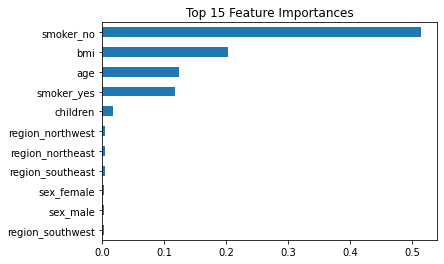

In [10]:
# %% 8. Feature importance (RF)
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)[:15]
importances.plot.barh(); plt.gca().invert_yaxis(); plt.title('Top 15 Feature Importances');

In [11]:
# %% 9. Export artefacts for Streamlit
OUT = Path('.')
pickle.dump(preprocess, open(OUT/'preprocess.pkl','wb'))
pickle.dump(feature_names, open(OUT/'feature_names.pkl','wb'))
pickle.dump(rf, open(OUT/'rf_model.pkl','wb'))

print('✅ Saved preprocess.pkl, feature_names.pkl, rf_model.pkl')

✅ Saved preprocess.pkl, feature_names.pkl, rf_model.pkl


### ⚠️ Debug tips
* **NotFittedError** → you forgot `preprocess.fit()` before transform or model.fit.
* **ValueError: number of features** → `raw_input` in Streamlit not matching `feature_names` order.
* **EOFError loading pkl** → wrong working directory; check `Path.cwd()` or move files.